In [237]:
import numpy as np

def forward_sample(Q, T, start_time, start_state):

    current_time = start_time
    current_state = start_state
    path = [(current_time, current_state)]

    while  T>0:
        # Get rate for current state
        Qa = -Q[current_state, current_state]

        # Sample waiting time from exponential distribution
        tau = np.random.exponential(1/Qa)

        # If waiting time exceeds remaining time, we're done
        if tau > T:
            break
        T-=tau
        # Update current time
        current_time += tau

        # Calculate transition probabilities from current state
        probs = np.array([Q[current_state,j]/Qa if j != current_state else 0
                         for j in range(len(Q))])

        # Sample new state
        new_state = np.random.choice(len(Q), p=probs)

        # Add transition to path
        path.append((current_time, new_state))
        current_state = new_state

    return path,current_state

In [238]:
Q = np.array([
        [-1.0, 0.5, 0.5],
        [0.3, -0.6, 0.3],
        [0.2, 0.2, -0.4]])

    # Generate sample path
path,curr_state = forward_sample(Q, 10.0,0,0)
for t, state in path:
    print(f"Time: {t:.2f}, State: {state}")

Time: 0.00, State: 0
Time: 2.44, State: 1
Time: 2.87, State: 2
Time: 5.37, State: 1
Time: 5.60, State: 2
Time: 8.04, State: 0


In [239]:
def modified_rejection_sampling(Q, T, a, b):
  while True:
    if a == b:
      # Case 1: Same beginning and ending states
      path = [(0, a)]
      Qa = -Q[a,a]
      tau = np.random.exponential(1/Qa)

      if tau > T:
        return path

      additional_path, end_state = forward_sample(Q,T,0, a)
      path.extend(additional_path)

      if end_state == a:
        return path

    else:
        # Case 2: Different beginning and ending states
      path = [(0, a)]
      Qa = -Q[a,a]
      # Sample first transition time using inverse transformation method as per (2.1) in report
      u = np.random.uniform(0,1)
      tau = -np.log(1 - u*(1 - np.exp(-T*Qa)))/Qa
      # Sample first new state
      probs = np.array([Q[a,j]/Qa if j != a else 0 for j in range(len(Q))])
      first_state = np.random.choice(len(Q), p=probs)
      path.append((tau, first_state))
      # Continue with forward sampling with period [tau,T]
      additional_path, end_state = forward_sample(Q,T,tau, first_state)
      path.extend(additional_path)
      if end_state == b:
        return path

In [240]:
path = modified_rejection_sampling(Q, 10.0,0,0)
for t, state in path:
    print(f"Time: {t:.2f}, State: {state}")

Time: 0.00, State: 0
Time: 0.00, State: 0
Time: 1.22, State: 1
Time: 5.08, State: 2
Time: 8.61, State: 0


In [241]:
path = modified_rejection_sampling(Q, 10.0,0,2)
for t, state in path:
    print(f"Time: {t:.2f}, State: {state}")

Time: 0.00, State: 0
Time: 0.33, State: 2
Time: 0.33, State: 2
Time: 0.51, State: 1
Time: 2.35, State: 0
Time: 3.06, State: 2
Time: 5.63, State: 1
Time: 6.42, State: 2
Time: 6.44, State: 1
Time: 8.05, State: 0
Time: 9.80, State: 2


In [242]:
import numpy as np
from scipy.linalg import expm, eigh
from scipy.optimize import root_scalar

def direct_sampling(Q, T, a, b):

  def get_eigendecomposition(Q):
    eigenvals, U = eigh(Q)
    U_inv = np.linalg.inv(U)
    return eigenvals, U, U_inv

  #As per (2.2)
  def get_Pab(t, eigenvals, U, U_inv):
    return np.sum([U[a,j] * U_inv[j,b] * np.exp(t*eigenvals[j]) for j in range(len(Q))])
  #As per (2.6) where J is defined as a piecewise function
  def get_J(lambda_j, Qa, T):
    if lambda_j + Qa == 0:
      return T * np.exp(T*lambda_j)
    return (np.exp(T*lambda_j) - np.exp(-Qa*T))/(lambda_j + Qa)
  #As per (2.6)
  def get_probs(eigenvals, U, U_inv, Qa, T):
    probs = np.zeros(len(Q))
    Pab_T = get_Pab(T, eigenvals, U, U_inv)

    for i in range(len(Q)):
      if i == a:
        continue
      numerator=0
      for j in range(len(Q)):
        J = get_J(eigenvals[j], Qa, T)
        numerator += U[i,j] * U_inv[j,b]
      probs[i] = Q[a,i]*numerator/Pab_T

    return probs


  #eigen decomposition for calculation
  eigenvals, U, U_inv = get_eigendecomposition(Q)
  #starting our simulation
  path = [(0, a)]
  current_time = 0
  current_state = a
  if a == b:
   # Calculate probability of no state change i.e. same state
    Qa = -Q[a,a]
    #finding the Pa (Probability that no state changes) as mention in (2.3) of report.
    Pa = np.exp(-Qa*T)/get_Pab(T, eigenvals, U, U_inv)

    # Sampling from bernauli by setting n=1 in binomial as there was no direct bernauli sample in numpy.
    if int(np.random.binomial(n=1, p=Pa))==1:
      return [(0, a)]  # No state change
  #if a is not equal to b or from bernauli we get 0 (for a==b condition)
  while current_time < T :
    if current_state == b and current_time >= T:
      break

    # Calculate transition probabilities
    Qa = -Q[current_state,current_state]
    #finding pi as mentioned in (2.6)
    probs = get_probs(eigenvals, U, U_inv, Qa, T-current_time)
    print(probs)

    #based on the above probability sampled next state
    next_state = np.random.choice(len(Q), p=probs/np.sum(probs))

    # Sample waiting time using inverse CDF method F(t)-u
    def cdf_equation(t, u):
      if t >= T-current_time:
        return 1 - u
      integral = 0
      Qai=Q[current_state,next_state]
      exp_term = np.exp(-Qa*t)
      for j in range(len(Q)):
        J = get_J(eigenvals[j], Qa, t)
        integral += U[next_state,j] * U_inv[j,b] * J
      return exp_term*Qai*integral/get_Pab(T-current_time, eigenvals, U, U_inv) - u

    u = np.random.uniform()
    #finding the solution to F(t)-u
    sol = root_scalar(cdf_equation, args=(u,), bracket=[0, T-current_time])
    waiting_time = sol.root

    current_time += waiting_time
    path.append((current_time, next_state))
    current_state = next_state

  return path


path = direct_sampling(Q, T=30.0, a=0, b=2)
print("Sample path:", path)

[0.00000000e+00 7.82249025e-15 1.40917457e+02]
Sample path: [(0, 0), (30.0, 2)]


In [ ]:
# implementation of uniformization
import math
def uniformization(Q, T, n_max, start_state, end_state):
    # calculate mu = max absolute value diagonal entry
    states = [start_state]
    transition_times = []
    mu = np.max(np.absolute(np.diag(Q)))

    # calculate R = I + (1/mu)Q
    R = np.identity(len(Q)) + ((1/mu)*Q)
    PT = expm(Q*T)
    PT_ab = PT[start_state, end_state]
    # calculate distribution of n
    prob_n = []

    for i in range(n_max + 1):
        R_i = np.linalg.matrix_power(R, i)
        R_i_ab = R_i[start_state, end_state]
        prob = (np.exp(-mu*T)*np.power(mu*T, i)/math.factorial(i))*R_i_ab/PT_ab
        prob_n.append(prob)

    prob_n = np.array(prob_n)
    prob_n /= np.sum(prob_n)

    n = np.random.choice(np.arange(len(prob_n)), p=prob_n)
    if n==0:
        # start state and end state are same and there were no transitions
        return states, transition_times
    
    if n==1:
        # get a uniformly random value in [0,T]
        transition_times.append(np.random.uniform(0, T))
        states.append(end_state)
        return states, transition_times
    
    transition_times = np.sort(np.random.uniform(0, T, n))
    
    for i in range(1, n):
        current_state = states[-1]
        remaining_transitions = n - i
        probs = []
        for j in range(R.shape[0]):
            R_j_b = np.linalg.matrix_power(R, remaining_transitions)[j, end_state]
            R_current_j = R[current_state, j]
            probs.append(R_current_j * R_j_b)
        probs = np.array(probs)
        probs /= np.sum(probs)
        next_state = np.random.choice(np.arange(R.shape[0]), p=probs)
        states.append(next_state)

    states.append(end_state)
    return states, transition_times

Q = np.array(
    [[-0.2, 0.1, 0.1],
    [0.4, -0.6, 0.2],
    [0.1, 0.8, -0.9]]
)

states, transition_times = uniformization(Q, 10, 20, 0, 2)


[ 0.00000000e+00  0.00000000e+00 -8.66724314e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -1.24635839e-16  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -1.64356605e-16  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -1.88578169e-16  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -4.24830239e-17  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -2.09289435e-16  0.00000000e+00]
[ 0.00000000e+00  0.00000000e+00 -2.18104224e-16  0.00000000e+00]
[ 0.000000

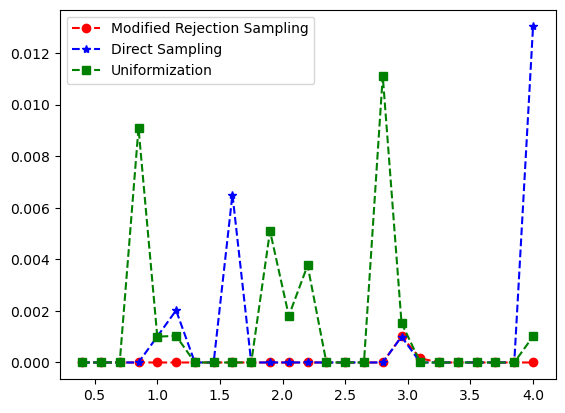

In [244]:
import time
import matplotlib.pyplot as plt
# simulation of molecular evolution at nucleotide level
# state space is A, G, C, T
#K = 2 and 7 = (0.2, 0.3, 0.3, 0.2)
k = 2
pi = [0.2, 0.3, 0.3, 0.2]
Q_ = np.array(
    [
        [-1.1, 0.6, 0.3, 0.2],
        [0.4, -0.9, 0.3, 0.2],
        [0.2, 0.3, -0.9, 0.4],
        [0.2, 0.3, 0.6, -1.1]
    ]
)
# Q_/s = Q
# (1/s)(0.2*1.1 + 0.3*0.9 + 0.3*0.9 + 0.2*1.1) = 1
s = 0.2*1.1 + 0.3*0.9 + 0.3*0.9 + 0.2*1.1
Q = Q_/s
# get different time intervals of simulation (evolutionary distances)
simulation_times = np.linspace(0.4, 4, 25)
cpu_time_mr = []
cpu_time_ds = []
cpu_time_u = []
for T in simulation_times:
    start = time.time()
    lst = modified_rejection_sampling(Q, T, 0, 0) # A to A
    end = time.time()
    mrtransition_times_aa = [i[0] for i in lst]
    mrstates_aa = [i[1] for i in lst]

    cpu_time_mr.append(end - start)

    start = time.time()
    lst = direct_sampling(Q, T, 0, 0)
    end = time.time()
    dstransition_times_aa = [i[0] for i in lst]
    dsstates_aa = [i[1] for i in lst]
    
    cpu_time_ds.append(end - start)

    start = time.time()
    ustates_aa, utransition_times_aa = uniformization(Q, T, 50, 0, 0) # A to A
    end = time.time()
    cpu_time_u.append(end - start)

plt.plot(simulation_times, cpu_time_mr, 'ro--', label="Modified Rejection Sampling")
plt.plot(simulation_times, cpu_time_ds, 'b*--', label="Direct Sampling")
plt.plot(simulation_times, cpu_time_u, 'gs--', label="Uniformization")
plt.legend()
plt.show()



# Comprehensive CTMC Sampling Algorithm Selection Guide

## 1. Modified Rejection Sampling (Algorithm 2)

**Best Used When:**
- Acceptance probability is high (pacc > ~0.1)
- Beginning and ending states are the same (a=b)
- Short time intervals with different states (a≠b)
- Computational resources are limited
- Simple, common transitions
- Quick implementation needed

**Advantages:**
- Simple implementation
- Low overhead per iteration
- Low per-sample computational cost
- Minimal memory requirements
- No matrix decomposition needed

**Avoid When:**
- Time interval T is large with small stationary probability πb
- Rare transitions between states
- Acceptance probability is very low (pacc < ~0.01)
- When multiple samples are needed from the same rate matrix

## 2. Direct Sampling (Algorithm 3)

**Best Used When:**
- Acceptance probability for rejection sampling would be very low
- Multiple samples needed from same Q matrix
- Dealing with sparse rate matrices
- Need guaranteed acceptance of samples
- Rare transitions between states
- Moderate to large time intervals
- When rejection sampling has low acceptance probability

**Advantages:**
- No rejection step - all samples valid
- Efficient for multiple samples (reuse eigendecomposition)
- Works well with rare transitions
- Handles rare transitions well
- Guaranteed acceptance

**Avoid When:**
- Simple transitions with high acceptance probability
- Limited computational resources (due to eigendecomposition)
- Single sample needed from dense rate matrix
- Very small time intervals
- When matrix decomposition is expensive relative to needed samples



